In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
paultimothymooney_chest_xray_pneumonia_path = kagglehub.dataset_download('paultimothymooney/chest-xray-pneumonia')

print('Data source import complete.')


100%|██████████| 2.29G/2.29G [01:16<00:00, 32.0MB/s]

Extracting files...


Data source import complete.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os
from PIL import Image
import itertools

import time
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback

In [ ]:
# Assuming the dataset was downloaded using kagglehub
# and the path is stored in paultimothymooney_chest_xray_pneumonia_path

# Update the train_data_path with the correct path
train_data_path = os.path.join(paultimothymooney_chest_xray_pneumonia_path, 'chest_xray', 'train')

filepaths = []
labels = []

folds = os.listdir(train_data_path)
for file in folds:
    foldpath = os.path.join(train_data_path, file)
    filelist = os.listdir(foldpath)

    for f in filelist:
        fpath = os.path.join(foldpath, f)
        filepaths.append(fpath)
        labels.append(file)

FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')

df = pd.concat([FSeries, LSeries], axis=1)

In [ ]:
# Update the train_data_path with the correct path
valid_data_dir = os.path.join(paultimothymooney_chest_xray_pneumonia_path, 'chest_xray', 'val')
filepaths = []
labels = []

folds = os.listdir(valid_data_dir)
for fold in folds:
    foldpath = os.path.join(valid_data_dir, fold)
    filelist = os.listdir(foldpath)

    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')

valid = pd.concat([FSeries, LSeries], axis=1)

In [ ]:
# Function to create an EfficientNetB0-based model
def create_efficientnet_model(input_shape=(224, 224, 3)):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model for transfer learning

    model = Sequential([
        base_model,
        # GlobalAveragePooling2D(),  # Reduces the spatial dimensions to a single vector
        # Dense(2, activation='softmax')  # Output layer for two classes
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')  # Adjust for 2 classes: Normal and Pneumonia
    ])
    return model

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/content/efficientNet_1.h5')


In [ ]:
# Load the EfficientNet model
# model = create_efficientnet_model()
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │      16,056,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,106,663 (76.70 MB)

 Trainable params: 16,057,090 (61.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 2 (12.00 B)

In [ ]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=42)
valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=42)

In [ ]:
batch_size = 16
img_size = (224, 224)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
val_gen= ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = val_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 4172 validated image filenames belonging to 2 classes.
Found 522 validated image filenames belonging to 2 classes.
Found 522 validated image filenames belonging to 2 classes.


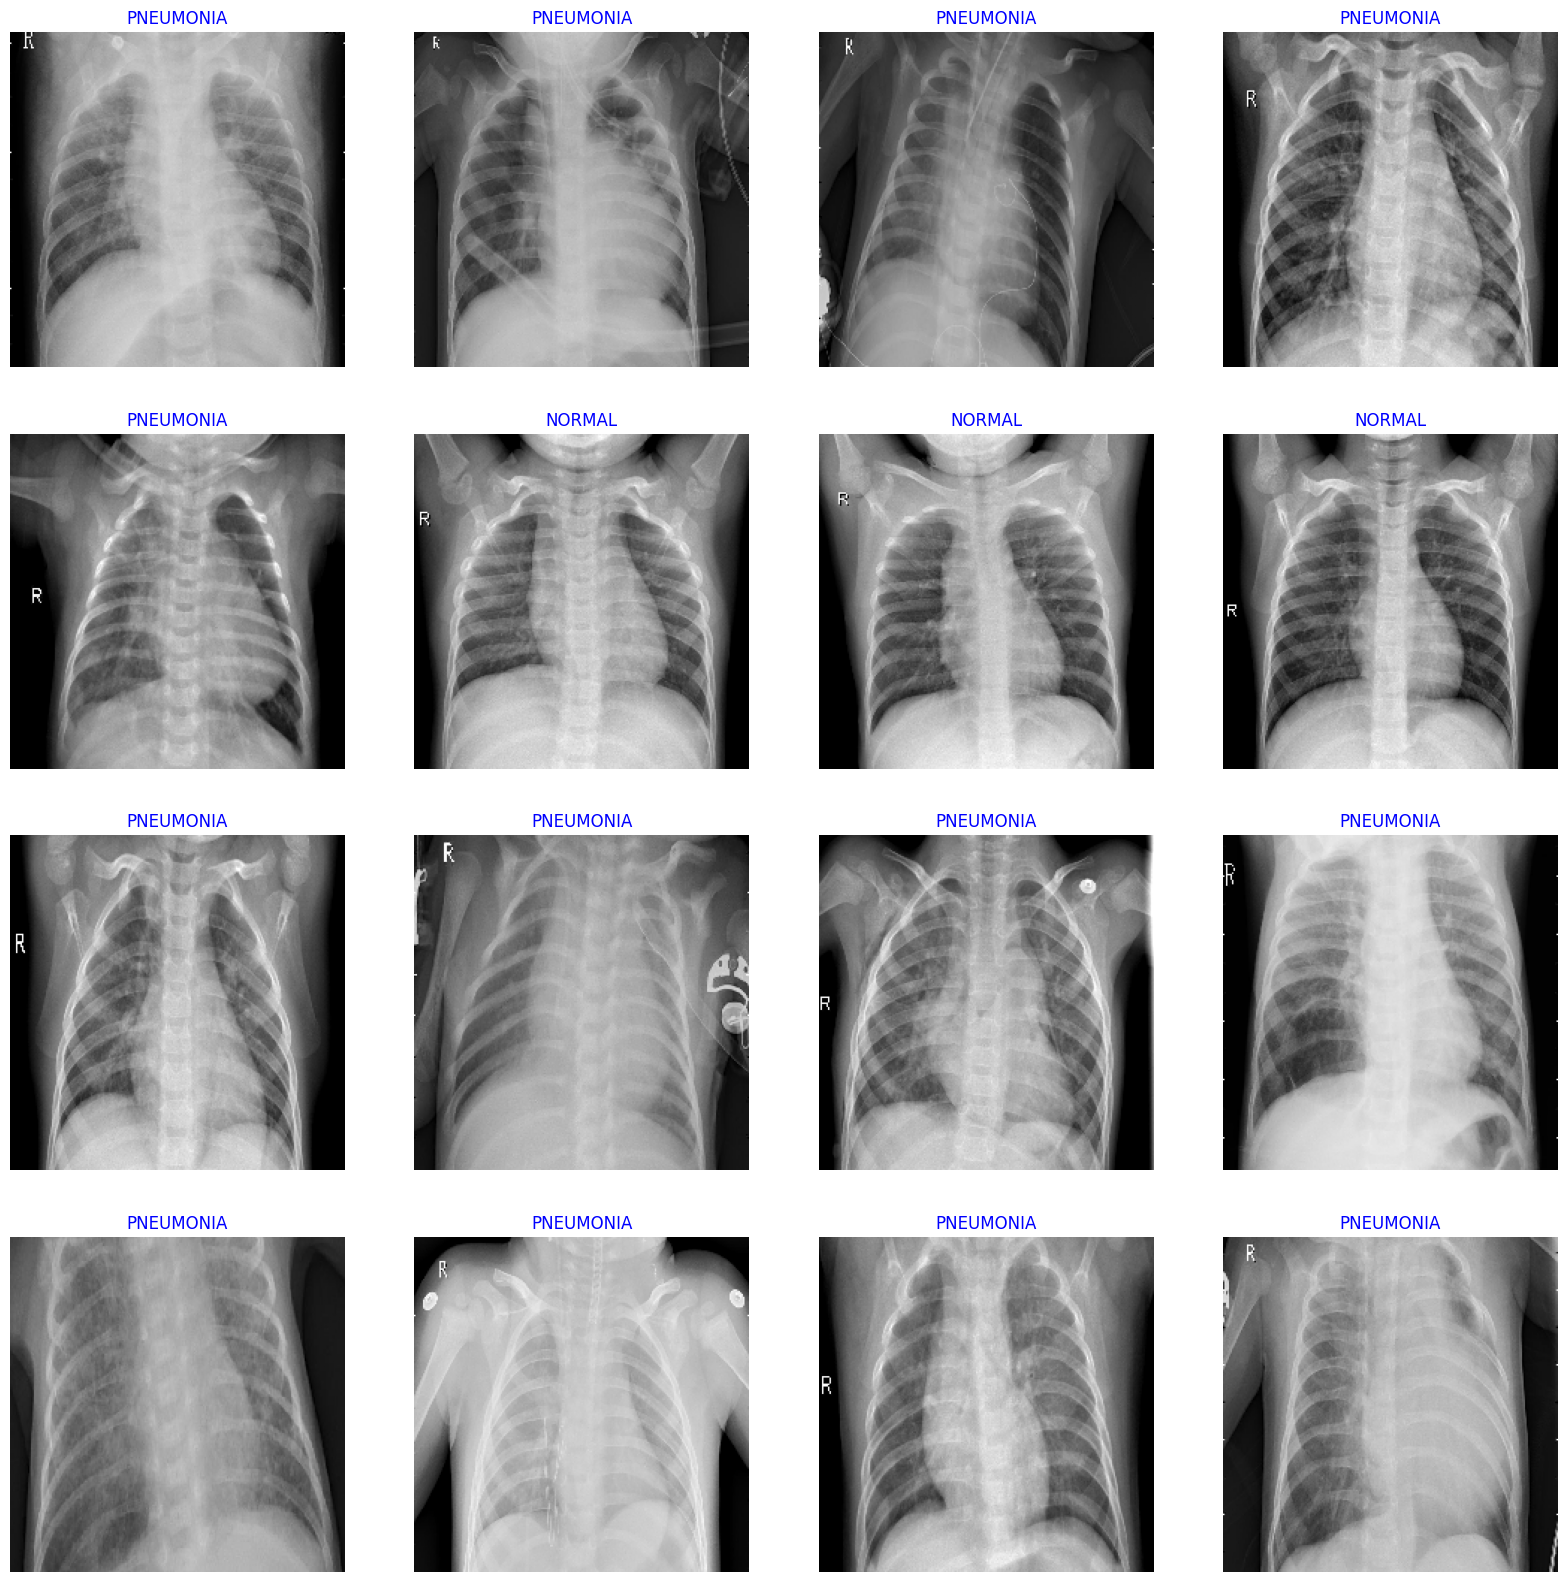

In [ ]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)

plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'blue' , fontsize= 12)
    plt.axis('off')
plt.show()

In [ ]:
# Train the model
epochs = 50
history = model.fit(train_gen, epochs=epochs, verbose=1, validation_data=valid_gen, shuffle=False)

Epoch 1/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 48s 185ms/step - accuracy: 0.9885 - loss: 0.0305 - val_accuracy: 0.9885 - val_loss: 0.0250
Epoch 2/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 80s 176ms/step - accuracy: 0.9919 - loss: 0.0248 - val_accuracy: 0.9828 - val_loss: 0.0520
Epoch 3/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 45s 171ms/step - accuracy: 0.9885 - loss: 0.0246 - val_accuracy: 0.9943 - val_loss: 0.0195
Epoch 4/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 47s 179ms/step - accuracy: 0.9953 - loss: 0.0125 - val_accuracy: 0.9943 - val_loss: 0.0151
Epoch 5/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 45s 173ms/step - accuracy: 0.9908 - loss: 0.0239 - val_accuracy: 0.9885 - val_loss: 0.0219
Epoch 6/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 45s 173ms/step - accuracy: 0.9945 - loss: 0.0131 - val_accuracy: 0.9904 - val_loss: 0.0326
Epoch 7/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 47s 180ms/step - accuracy: 0.9939 - loss: 0.0235 - val_accuracy: 0.9847 - val_loss: 0.0357
Epoch 8/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 45s 173ms/step - accuracy: 0.9929 - loss: 0

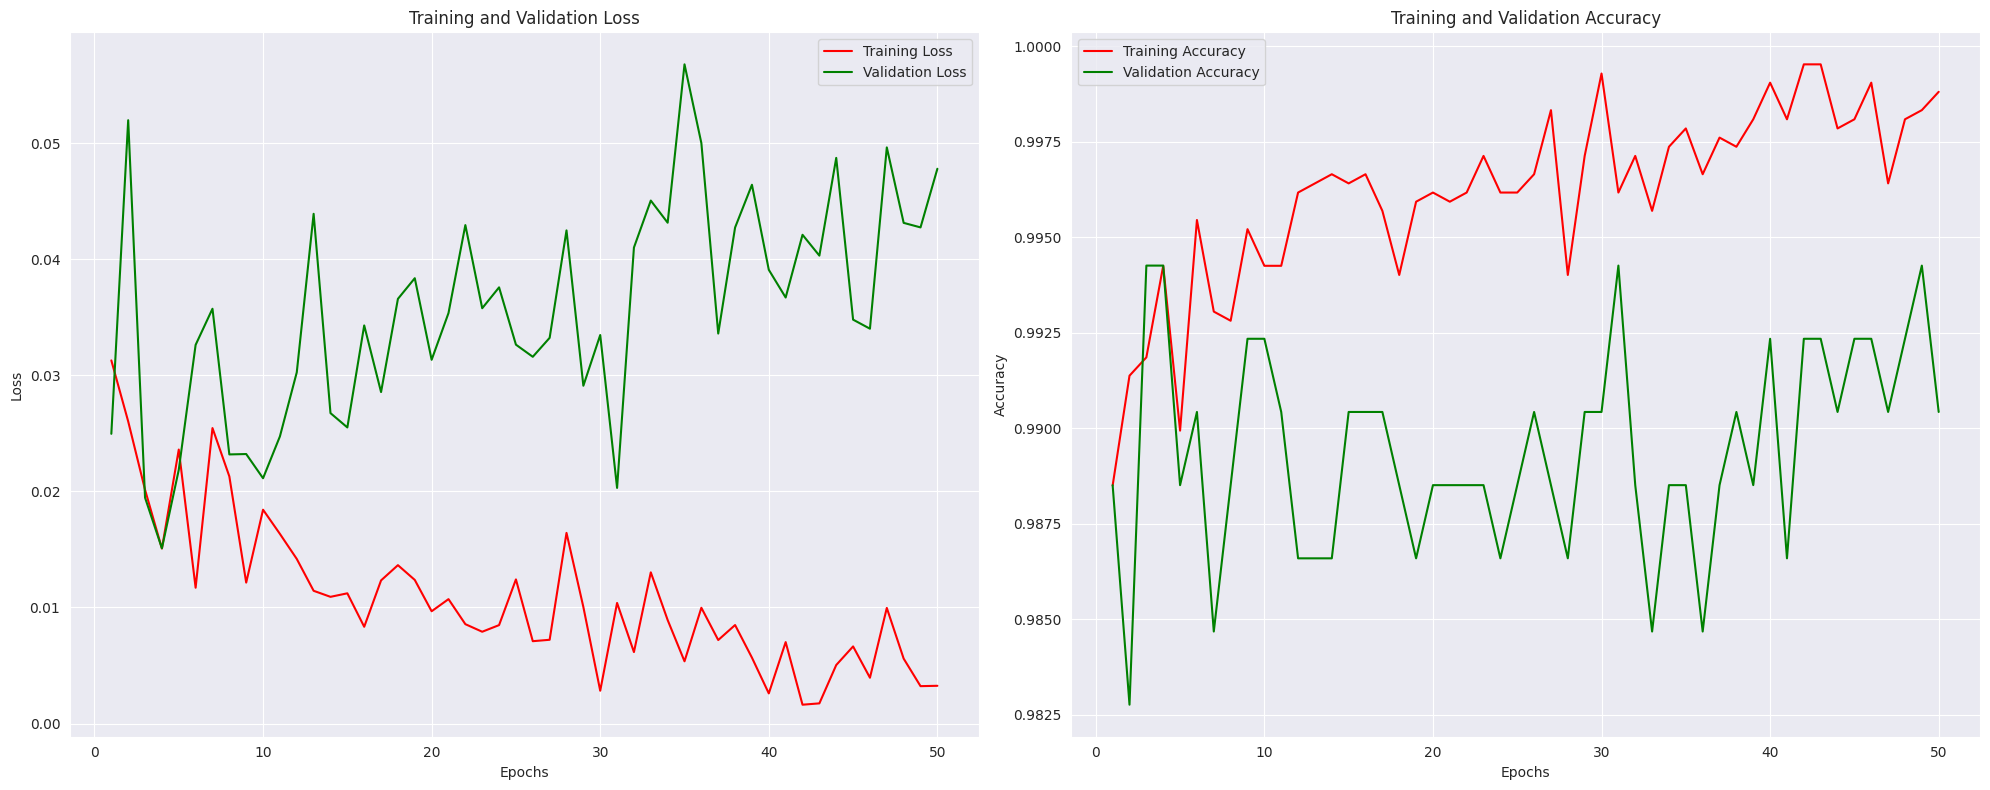

In [ ]:
# Plot training history
import matplotlib.pyplot as plt

tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

Epochs = [i + 1 for i in range(len(tr_acc))]

plt.figure(figsize=(20, 8))

# Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training Loss')
plt.plot(Epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

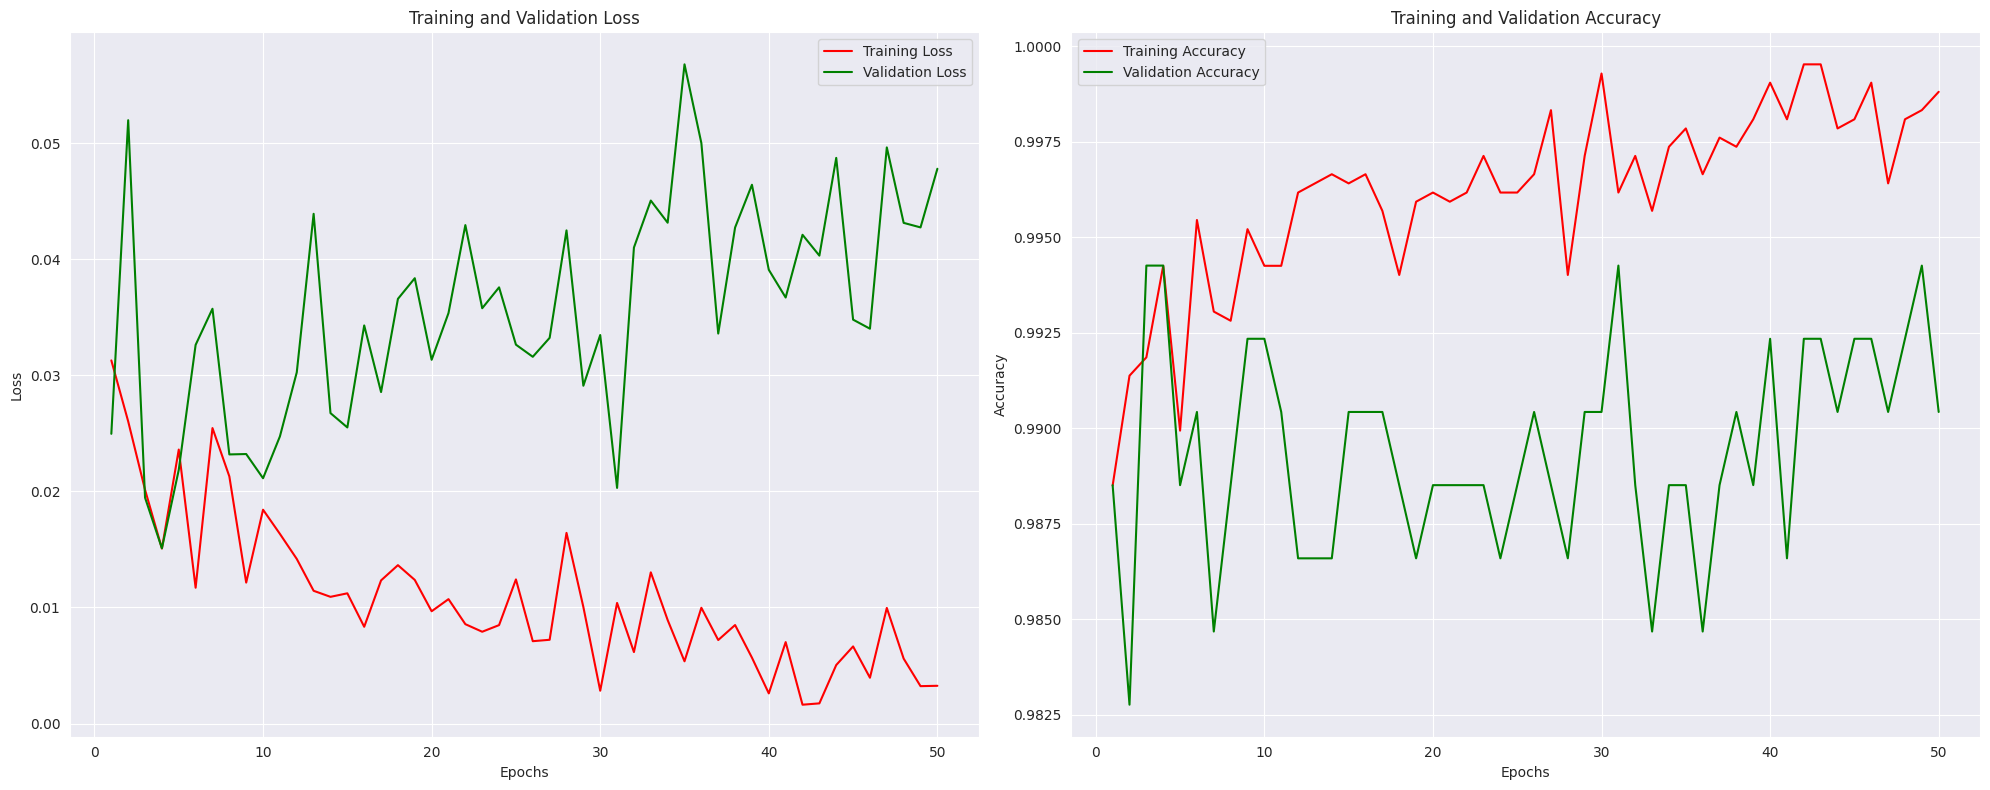

In [ ]:
# Plot training history
import matplotlib.pyplot as plt

tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

Epochs = [i + 1 for i in range(len(tr_acc))]

plt.figure(figsize=(20, 8))

# Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training Loss')
plt.plot(Epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import time

# Evaluate the model and time the operations
start_time = time.time()
train_score = model.evaluate(train_gen, verbose=1)
train_time = time.time() - start_time
print(f"Train evaluation time: {train_time:.2f} seconds")

start_time = time.time()
valid_score = model.evaluate(valid_gen, verbose=1)
valid_time = time.time() - start_time
print(f"Validation evaluation time: {valid_time:.2f} seconds")

start_time = time.time()
test_score = model.evaluate(test_gen, verbose=1)
test_time = time.time() - start_time
print(f"Test evaluation time: {test_time:.2f} seconds")

261/261 ━━━━━━━━━━━━━━━━━━━━ 43s 165ms/step - accuracy: 1.0000 - loss: 5.4349e-05
Train evaluation time: 82.42 seconds
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 0.9900 - loss: 0.0619
Validation evaluation time: 5.40 seconds


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 170ms/step - accuracy: 0.9921 - loss: 0.0283
Test evaluation time: 10.65 seconds


In [ ]:
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])


Train Loss:  6.926511559868231e-05
Train Accuracy:  1.0
--------------------
Validation Loss:  0.04779956117272377
Validation Accuracy:  0.99042147397995
--------------------
Test Loss:  0.04127480462193489
Test Accuracy:  0.99042147397995


In [ ]:
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])


Train Loss:  6.926511559868231e-05
Train Accuracy:  1.0
--------------------
Validation Loss:  0.04779956117272377
Validation Accuracy:  0.99042147397995
--------------------
Test Loss:  0.04127480462193489
Test Accuracy:  0.99042147397995


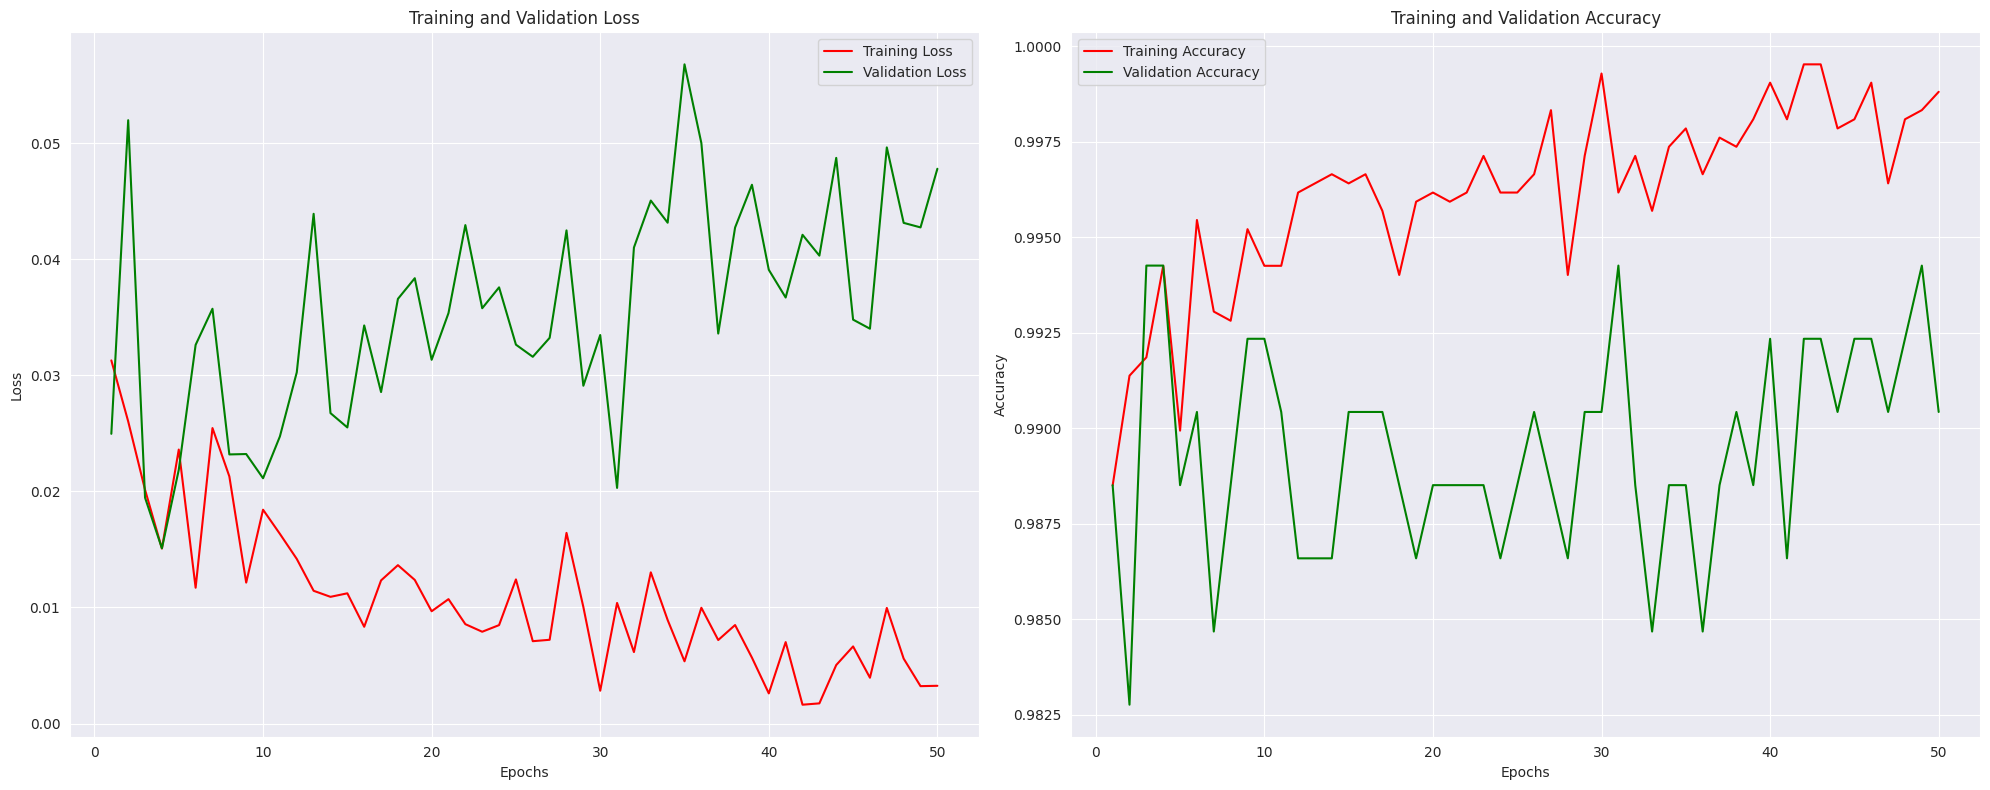

In [ ]:
# Plot training history
import matplotlib.pyplot as plt

tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

Epochs = [i+1 for i in range(len(tr_acc))]

plt.figure(figsize=(20, 8))

# Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training Loss')
plt.plot(Epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)
cm


33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 331ms/step


array([[132,   1],
       [  4, 385]])

33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step


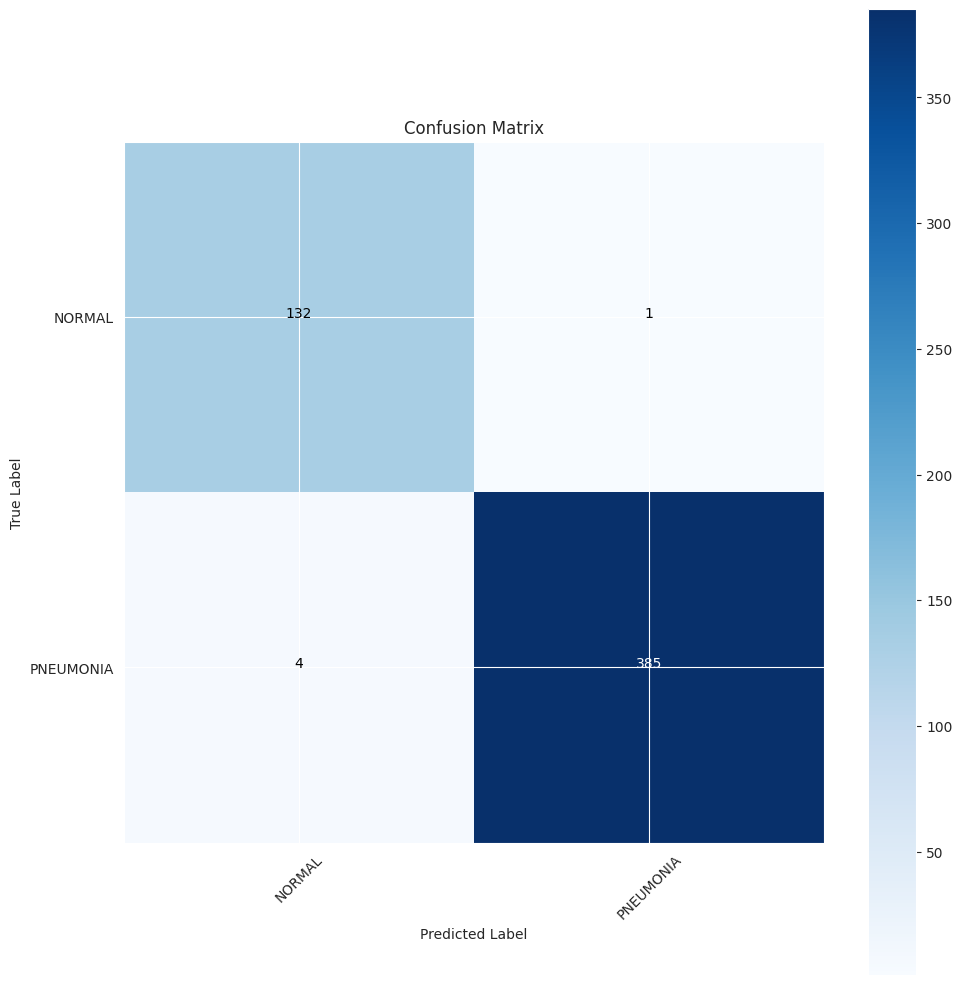

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import itertools

preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center',
             color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
# Classification Report
print(classification_report(test_gen.classes, y_pred, target_names=classes))

              precision    recall  f1-score   support

      NORMAL       0.97      0.99      0.98       133
   PNEUMONIA       1.00      0.99      0.99       389

    accuracy                           0.99       522
   macro avg       0.98      0.99      0.99       522
weighted avg       0.99      0.99      0.99       522



1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


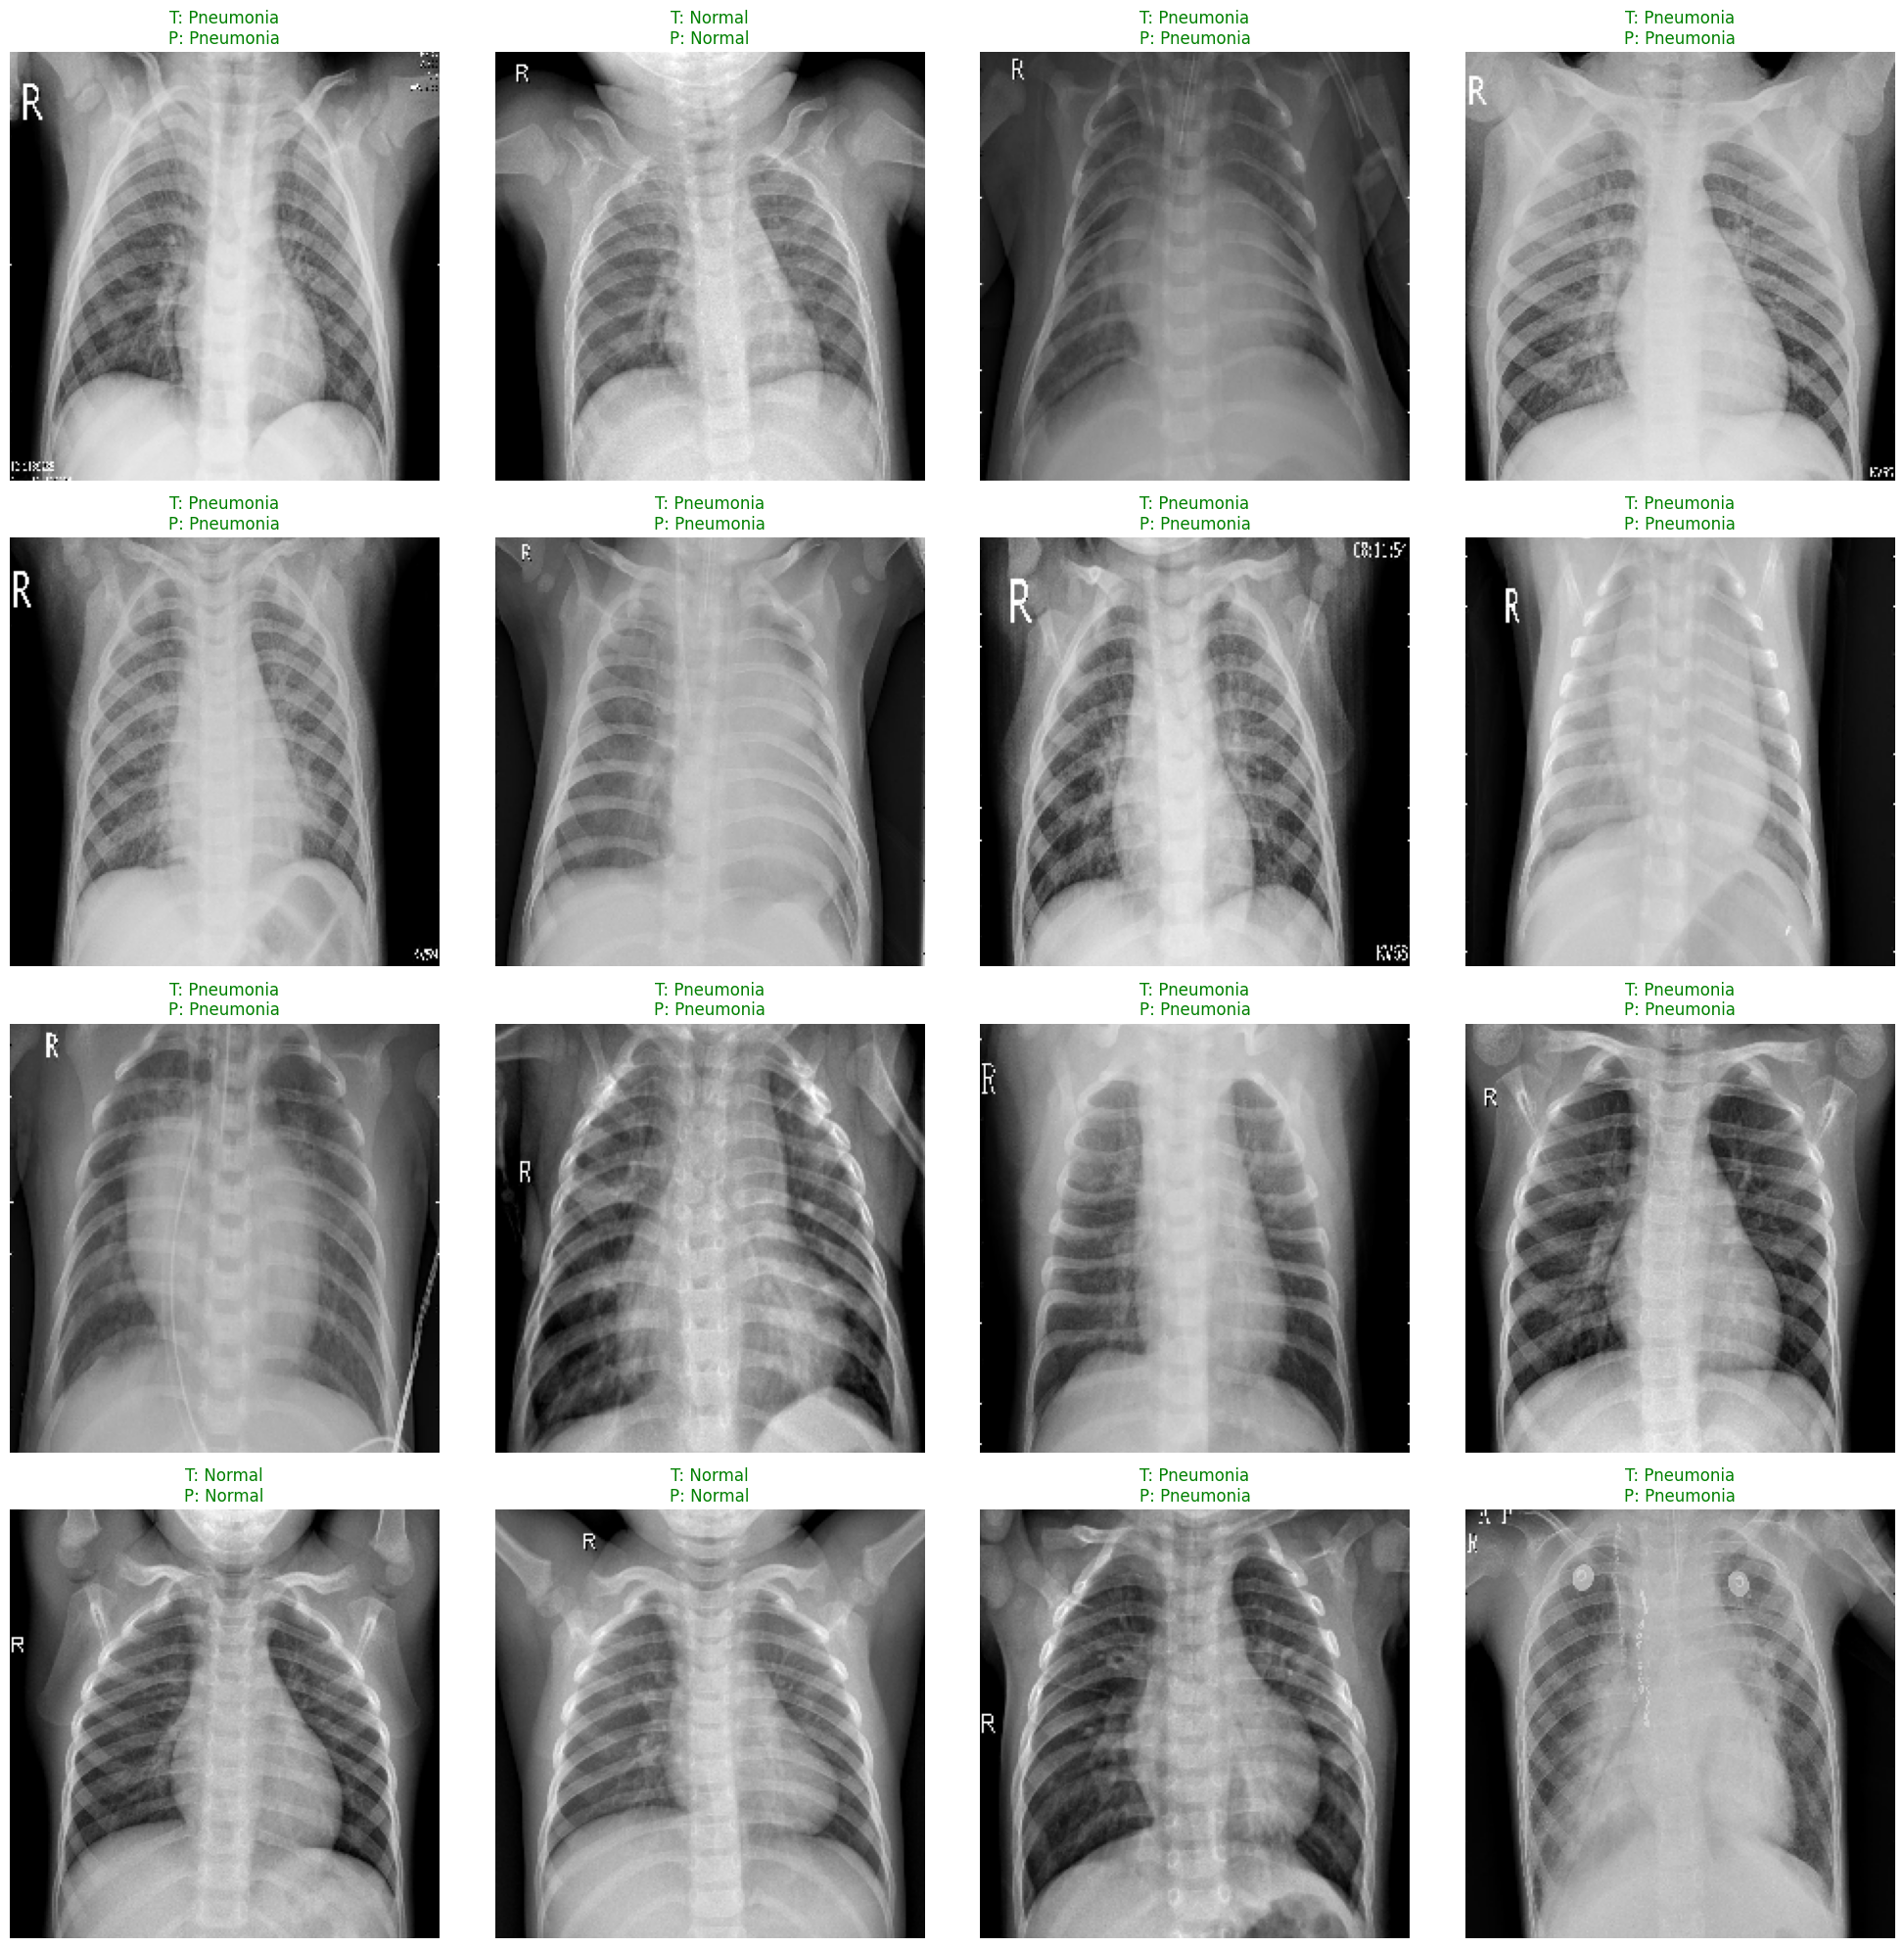

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class_names = ["Normal", "Pneumonia"]

x_test, y_true = next(test_gen)
batch_size = x_test.shape[0]
n_images = min(16, batch_size)

x_test = x_test[:n_images]
y_true = y_true[:n_images]

y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

plt.figure(figsize=(20, 20))
for i in range(n_images):
    plt.subplot(4, 4, i + 1)
    plt.imshow(x_test[i].astype("uint8"))
    plt.axis("off")
    true_label = class_names[y_true_classes[i]]
    pred_label = class_names[y_pred_classes[i]]
    plt.title(f"T: {true_label}\nP: {pred_label}", color=("green" if true_label == pred_label else "red"))

plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path to test data directory
test_dir = "/content/drive/MyDrive/chest_xray/chest_xray/test"

# /content/drive/MyDrive/chest_xray/chest_xray/Test

# Define the ImageDataGenerator for the test set (no data augmentation needed)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)  # Normalize pixel values to [0, 1]

# Create test_batches
test_batches = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # Match the input size of your model
    batch_size=32,          # Number of images per batch
    class_mode='categorical',  # 'categorical' for multi-class; 'binary' for binary classification
    shuffle=False           # Do not shuffle to keep order for evaluation
)

# Print summary of test_batches
print(f"Number of batches: {len(test_batches)}")
print(f"Classes: {test_batches.class_indices}")

Found 660 images belonging to 3 classes.
Number of batches: 21
Classes: {'Data': 0, 'NORMAL': 1, 'PNEUMONIA': 2}


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path to test data directory
test_dir = "/content/drive/MyDrive/chest_xray/chest_xray/test"

# /content/drive/MyDrive/chest_xray/chest_xray/Test

# Define the ImageDataGenerator for the test set (no data augmentation needed)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)  # Normalize pixel values to [0, 1]

# Create test_batches
test_batches = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # Match the input size of your model
    batch_size=32,          # Number of images per batch
    class_mode='categorical',  # 'categorical' for multi-class; 'binary' for binary classification
    shuffle=False           # Do not shuffle to keep order for evaluation
)

# Print summary of test_batches
print(f"Number of batches: {len(test_batches)}")
print(f"Classes: {test_batches.class_indices}")

Found 660 images belonging to 3 classes.
Number of batches: 21
Classes: {'Data': 0, 'NORMAL': 1, 'PNEUMONIA': 2}


In [ ]:
# Measure prediction time for the entire test set
start_time = time.time()
predictions = model.predict(test_batches)
end_time = time.time()

# Calculate average prediction time per image
total_images = len(test_batches) * test_batches.batch_size
batch_time = end_time - start_time
average_time_per_image = batch_time / total_images

print(f"Batch prediction time: {batch_time:.2f} seconds")
print(f"Average prediction time per image: {average_time_per_image:.4f} seconds")

21/21 ━━━━━━━━━━━━━━━━━━━━ 90s 4s/step
Batch prediction time: 91.92 seconds
Average prediction time per image: 0.1368 seconds


In [ ]:
# Measure prediction time for the entire test set
start_time = time.time()
predictions = model.predict(test_batches)
end_time = time.time()

# Calculate average prediction time per image
total_images = len(test_batches) * test_batches.batch_size
batch_time = end_time - start_time
average_time_per_image = batch_time / total_images

print(f"Batch prediction time: {batch_time:.2f} seconds")
print(f"Average prediction time per image: {average_time_per_image:.4f} seconds")

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 300s 15s/step
Batch prediction time: 330.26 seconds
Average prediction time per image: 0.4915 seconds


In [ ]:
#save to h5 file

from tensorflow.keras.models import load_model

model.save(r'efficientNet_1.h5')
# keras.saving.save_model(model, 'my_model.keras')



In [ ]:
os.getcwd()

'/content'

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path to test data directory
test_dir = "/content/drive/MyDrive/chest_xray/chest_xray/test"

# Define the ImageDataGenerator for the test set (no data augmentation needed)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)  # Normalize pixel values to [0, 1]

# Create test_batches
test_batches = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # Match the input size of your model
    batch_size=32,          # Number of images per batch
    class_mode='categorical',  # 'categorical' for multi-class; 'binary' for binary classification
    shuffle=False           # Do not shuffle to keep order for evaluation
)

# Print summary of test_batches
print(f"Number of batches: {len(test_batches)}")
print(f"Classes: {test_batches.class_indices}")